In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.transfer import polar_symbols
from mpl_toolkits.axes_grid1 import ImageGrid

abtem.config.set({"local_diagnostics.progress_bar": False});

(walkthrough:contrast_transfer_function)=
# Contrast transfer function
The [contrast transfer function](https://en.wikipedia.org/wiki/Contrast_transfer_function) (CTF) describes the aberrations of the objective lens in HRTEM and  how the condenser system shapes the probe in STEM. Here we describe how to create a CTF with specific aberrations and how this affects the resulting images.

## Phase aberrations
Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice, aberrations cause the wave front to deviate from a spherical surface. In a polar representation, this deviation, or phase aberration, can be written as $\chi(k, \phi)$, where $k = \sqrt{k_x^2 + k_y^2}$ is the radial component and $\phi = \arctan(k_y / k_x)$ is the azimuthal component. We expand the phase error as a series expansion

$$ 
    \chi(k, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad ,
$$

where $n$ and $m$ are the radial and azimuthal order, respectively.

```{note}
*ab*TEM exclusively uses polar expansion coefficients; however, a conversion utility from the Cartesian to the polar representation is available in `abtem.waves.transfer.cartesian2polar`.
```

If the microscope is well aligned then off-axis aberrations (astigmatisms and comas) are small and the aberrations are dominated by the first two isotropic terms. The aberrations reduce to an expression you may be more familiar with 

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

````{note}
:class: dropdown

Note the sign convention used for the defocus ($\Delta f = -C_{1,1}$). Positive defocus is equivalent to backward free-space propagation, or equivalently, with a positive defocus, the focus is inside the potential. Below we propagate a probe wave function through vacuum by 5 Å, which is completely undone by applying a defocus of 5 Å, i.e. the assertion below is valid.

```python
propagator = FresnelPropagator()
 
probe1 = Probe(extent=10, gpts=256, energy=150e3, semiangle_cutoff=30).build().compute()

probe2 = probe1.propagate(dz = 5).apply_ctf(defocus = 5)

assert probe1 == probe2

```
````

In *ab*TEM, the `CTF` object takes parameters of the form `Cnm` and `phinm`, and some may alternatively also be given using their common aliases, e.g. `defocus = -C10`. The expansion is implemented up to 5th order and all the coefficients keyword are given in the table below.


```{list-table}
:header-rows: 1

* - 1st order
  - 2nd order
  - 3rd order
  - 4th order
  - 5th order
* - `C10`
  - `C21`, `phi21`
  - `C30`
  - `C41`, `phi41`
  - `C50`
* - `C12`, `phi12`
  - `C23`, `phi23`
  - `C32`, `phi32`
  - `C43`, `phi43`
  - `C52`, `phi52`
* - 
  - 
  - `C34`, `phi34`
  - `C45`, `phi45`
  - `C54`, `phi54`
* - 
  -
  -
  -
  - `C56`, `phi56`
```

### Point spread function

We can visualize each phase aberration by showing its effect on a small probe wave function. This is called the point spread function (PSF) and describes the response of an imaging system to a point source. In the image grid below, the indicated aberration is applied to the probe shown in the bottom left. Both magnitude and phase are indicated through domain coloring. The magnitude of the coefficients are scaled by the radial order according to a power law.

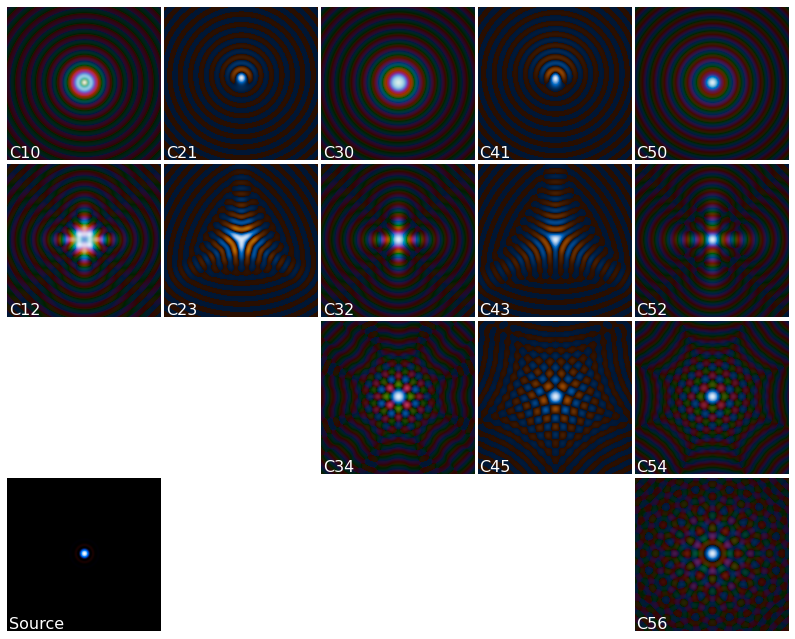

In [2]:
coefficients = tuple(symbol for symbol in polar_symbols if symbol[0] == "C")


def make_psf(aberration):
    psf = (
        abtem.Probe(
            energy=150e3, semiangle_cutoff=30, gpts=(512, 512), extent=50, **aberration
        )
        .build()
        .phase_shift(np.pi / 2)
        .images()
        .crop(extent=(15, 15), offset=(17.5, 17.5))
        .compute()
    )
    return psf


def make_coefficient_plot(func, coefficients):
    orders = [int(c[1]) for c in coefficients]
    cols = [x - 1 for x in orders]
    rows = [j for i in range(1, max(orders) + 1) for j in range(orders.count(i))]
    aberrations = [
        {coefficient: 50 ** order} for coefficient, order in zip(coefficients, orders)
    ]
    images = [func(aberration) for aberration in aberrations]

    nrows, ncols = (4, 5)
    fig = plt.figure(1, figsize=(14, 14))
    axes = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), **{"axes_pad": 0.05},)

    for ax in axes:
        ax.set_axis_off()

    for image, row, col, coefficient, order in zip(
        images, rows, cols, coefficients, orders
    ):
        i = np.ravel_multi_index((row, col), (nrows, ncols))
        axes[i].annotate(f"{coefficient}", xy=(0.15, 0.25), color="w", size=16)

        vmin = np.abs(image.array).min() + np.abs(image.array).ptp() * 0.2
        vmax = np.abs(image.array).max() + np.abs(image.array).ptp() * 0.07

        image.show(
            ax=axes[i], complex_coloring_kwargs={"saturation": 2}, vmin=vmin, vmax=vmax
        )

    left_corner = np.ravel_multi_index((nrows - 1, 0), (nrows, ncols))
    func({}).show(ax=axes[left_corner])
    axes[left_corner].annotate(f"Source", xy=(0.15, 0.25), color="w", size=16)


make_coefficient_plot(make_psf, coefficients)

### Applying phase aberrations to wave functions
Given an exit wave function $\phi_{exit}$ and an objective lens with a phase error $\chi$ (and infinite aperture), the wave function at the image plane is given by

$$  
    \psi_{image}(k, \phi) = \psi_{exit}(k, \phi) \exp(-i \chi(k, \phi)) \quad .
$$ (eq:user_guide:walkthrough:contrast_transfer_function:apply_ctf)

We start by simulating an exit wave for an MoS<sub>2</sub> model. An atomic model with a hexagonal cell is created using the ASE's [`mx2`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#ase.build.mx2) method, which we make orthogonal using `orthogonalize_cell` (see our walkthrough on [atomic models](atomic_models.ipynb)).

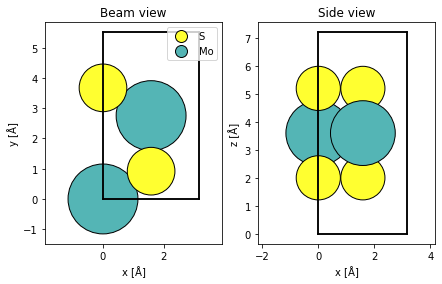

In [3]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", legend=True)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view");

We run the multislice algorithm for an incident plane wave at $80 \ \mathrm{keV}$ through a default potential (using the Lobato indepdent atom parameterization, see our [walkthrough on potentials](potentials.ipynb)).

In [4]:
exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.02).multislice(atoms)

We create a compatible `CTF` for electrons of the same energy of $80 \ \mathrm{keV}$. The spherical aberration will be set to $-20~\mu \mathrm{m}$ (remember that *ab*TEM uses units of $\mathrm{Å}$) and the defocus is set to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy) (here $-111.92 \ \mathrm{Å}$).

In [5]:
Cs = -20e-6 * 1e10  # 20 micrometers

ctf = abtem.CTF(Cs=Cs, energy=80e3)
ctf.defocus = ctf.scherzer_defocus

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -111.92 Å


The aberrations may also be given as a dictionary.

In [6]:
aberration_coefficients = {"C10": -ctf.defocus, "C30": Cs}

ctf = abtem.CTF(aberration_coefficients=aberration_coefficients, energy=ctf.energy)

We can get radial `LineProfiles` up to a given angle to preview the CTF, which *by convention* display the imaginary part of complex exponential of the phase error.

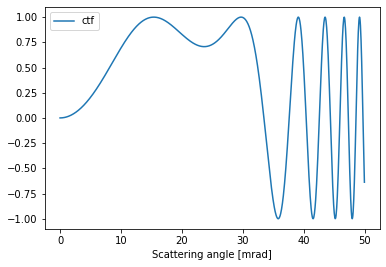

In [7]:
ctf.profiles(max_angle=50).show(units="mrad");

To perform the multiplication in Eq. {eq}`eq:user_guide:walkthrough:contrast_transfer_function:apply_ctf`, we use the `apply_ctf` method.

In [8]:
image_wave = exit_wave.apply_ctf(ctf)

We show the exit wave function and the wave function at image plane below.

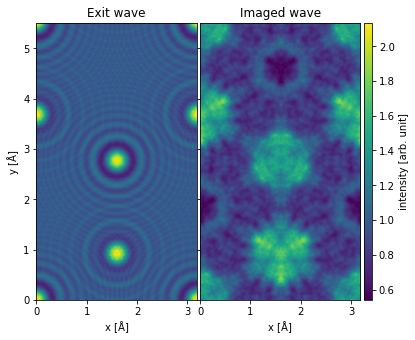

In [9]:
abtem.stack([exit_wave, image_wave], ("Exit wave", "Imaged wave")).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

Without an aperture, the high-frequency components of the CTF lead to the observed complicated contrast variation.

### Focal series

It common that the aberrations of your microscope are not known exactly, and thus it is useful to simulate an ensemble of images with different aberrations. 

We create an ensemble of `CTF`s for an range of defocii.

In [10]:
ctf_ensemble = abtem.CTF(Cs=-25e-6 * 1e10, energy=80e3)

ctf_ensemble.C10 = np.linspace(0, -ctf_ensemble.scherzer_defocus, 5)

When this `CTF` is applied to the wave function we obtain an ensemble of wave functions.

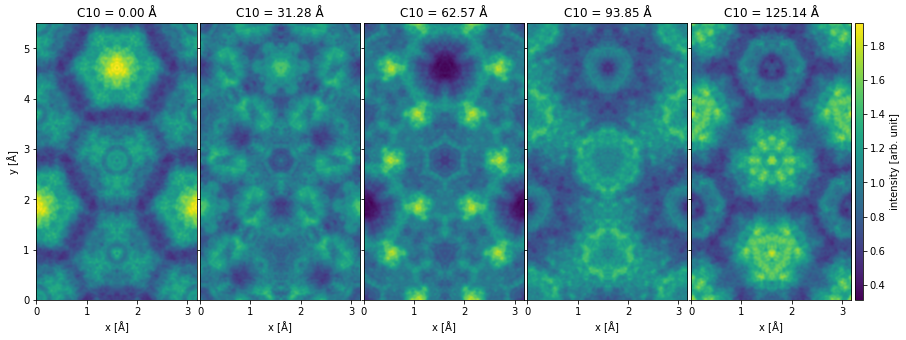

In [11]:
waves_image_series = exit_wave.apply_ctf(ctf_ensemble)

waves_image_series.show(
    figsize=(18, 5),
    cbar=True,
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
);

## Aperture

In practice, the maximum transferred frequency is limited by the aperture of the objective lens. This is conventionally described as a multiplication with the aperture function:

$$
    \psi_{\mathrm{image}}(k, \phi) = A(k) \exp[-i \chi(k, \phi)] \psi_{\mathrm{exit}}(k, \phi),
$$

where $A(k)$ is the aperture function

$$
    A(k) = \begin{cases} 1 & \text{if } x \geq k_{cut} \\ 0 & \text{if } x < k_{cut} \end{cases} .
$$

We will cut off the `CTF` at the angle corresponding to the Scherzer [point resolution](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus), which is defined as the angle where the phase of the `CTF` crosses the abscissa for the first time (`crossover_angle`).

In [12]:
ctf_cutoff = ctf.copy()

ctf_cutoff.semiangle_cutoff = ctf_cutoff.crossover_angle

print(f"cutoff = {ctf_cutoff.crossover_angle:.3f} mrad")

cutoff = 33.455 mrad


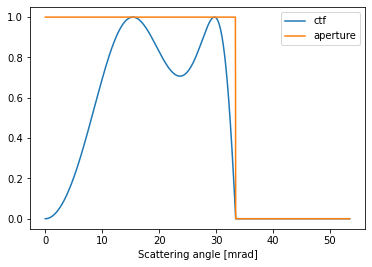

In [13]:
ctf_cutoff.profiles().show(units="mrad");

We show the resulting image below and see, as expected, that applying this aperture removes high-frequency information from the wave function intensity.

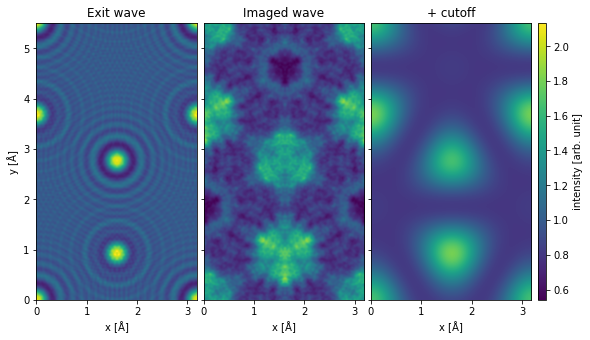

In [14]:
waves_cutoff = exit_wave.apply_ctf(ctf_cutoff)

abtem.stack(
    [exit_wave, image_wave, waves_cutoff], ("Exit wave", "Imaged wave", "+ cutoff")
).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.1},
    cbar=True,
);

## Partial coherence (quasi-coherent)
Partial coherence acts similarly to the aperture function to dampen the high spatial frequencies of the signal. Partial coherence may be approximated by multiplying the `CTF` by envelope functions:

$$
    \psi_{\mathrm{image}}(k, \phi) = \mathrm{CTF}(k, \phi) \psi_{\mathrm{exit}}(k, \phi),
$$

where the $\mathrm{CTF}$ is now given as

$$
    \mathrm{CTF}(k, \phi) = E_t(k) E_s(k) A(k) \exp[-i \chi(k, \phi)]
$$

and $E_t(k)$ and $E_s(k)$, to be defined below, are the temporal and spatial envelopes, respectively. 


```{warning}
Here partial coherence is applied using the convenient quasi-coherent approximation. This is only appropriate for HRTEM simulations when the effect is sufficiently small, but it is generally *never* appropriate for STEM simulations. The more accurate approach of using an incoherent summation is [introduced in a tutorial](../tutorials/partial_coherence.ipynb).
```

### Partial temporal coherence

The most important source of partial coherence in HRTEM is partial temporal coherence. A small spread in energy of the incident electrons, $\Delta E$, is due to the chromatic aberration of the objective lens equivalent to a small spread in defocus. Fluctuations in the focusing currents of the objective lens, $\Delta I$, also produce an incoherent spread in defocus. Combining these effects, the standard deviation of the focal spread may be written as

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2} \quad.
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. $C_c$ is the chromatic aberration coefficient. Assuming $\delta$ is small, and focal spread follows a Gaussian distribution, the temporal envelope may be written {cite}`kirkland`

$$
    E_t(k) = \exp\left[-\frac{1}{4} \left(\pi \lambda \delta \right)^2 k^4 \right] \quad .
$$

The parameter $\delta$ above is equivalent to the `focal_spread` keyword and given in $\mathrm{Å}$.

We calculate a realistic value of the focal spread to be $52.5 \ \mathrm{Å}$. This was estimated using a typical energy spread of $0.35 \ \mathrm{eV}$ for a non-monochromated beam and a typical chromatic aberration of $1.2 \ \mathrm{mm}$ which would be considered good for a microscope without chromatic aberration correction. We assume that the contributions to the focal spread from instabilities in the magnetic lenses are negligible.

In [15]:
Cc = 1.2e-3 * 1e10
energy = exit_wave.energy
energy_spread = 0.35

focal_spread = Cc * energy_spread / energy

print(f"focal spread = {focal_spread:.2f} Å")

focal spread = 52.50 Å


We show a plot of the resulting `CTF` below. Given this we may conclude that for a focal spread of this magnitude, the aperture will have almost no effect as the envelope already goes to zero at the cutoff.

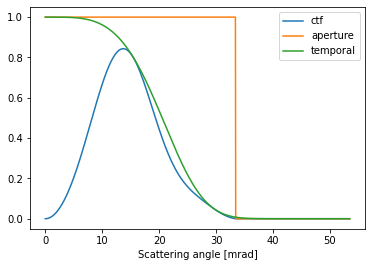

In [16]:
ctf_partial = ctf_cutoff.copy()
ctf_partial.focal_spread = focal_spread
ctf_partial.profiles().show(units="mrad");

### Partial spatial coherence

As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by *angular spread*. Assuming that each incident direction performs its own scattering and that the distribution of incident directions is small, it can be shown that the angular spread can be modelled by the spatial coherence envelope function{cite}`kirkland`, as given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) \quad .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent the `angular_spread` keyword and given in $\mathrm{mrad}$.

Given a modern electron source such as a field emission gun, the partial spatial coherence is typically negligible, even in microscopes without chromatic aberration correction.

Given an angular spread of $1 \ \mathrm{mrad}$, which would be considered large, we obtain the spatial envelope illustrated below, which we see has almost no effect in the presence of partial temporal coherence.

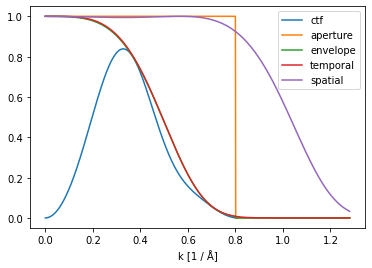

In [17]:
ctf_partial.angular_spread = 1

ctf_partial.profiles().show();

Finally we apply the `CTF` with the partial coherence envelope to the wave function. The effect is to further blur the image and to lower the contrast. 

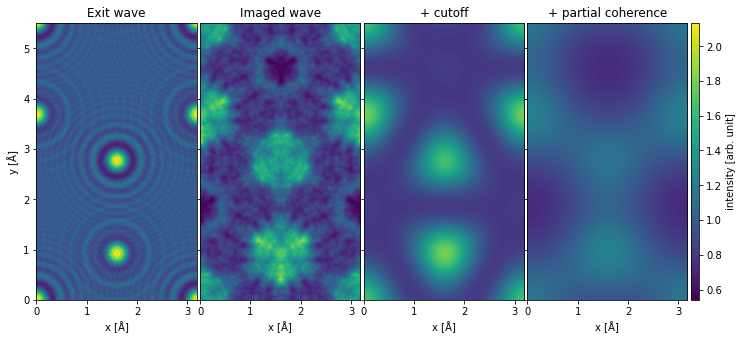

In [18]:
wave_partial = exit_wave.apply_ctf(ctf_partial)

abtem.stack(
    [exit_wave, image_wave, waves_cutoff, wave_partial],
    ("Exit wave", "Imaged wave", "+ cutoff", "+ partial coherence"),
).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

```{note}
Blurring can also be caused by noise leading to random deflection of the image relative to the detector, such as vibrations, drift of the stage and magnetic noise in the lenses. Such effects may be reasonably included by applying a Gaussian blur.
```